In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

In [409]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x)) 
    return exp_x / exp_x.sum(axis=0, keepdims=True)

def cross_entropy_derivative(output_activations, y):
    return output_activations - y



In [447]:
class MLP:
    def __init__(self, layer_sizes, scaler, verbose=False, beta_momentum=0.90, beta_rmsprop=0.999, epsilon=1e-8):

        self.layer_sizes = layer_sizes
        # Decided to use he method for initialization
        self.weights = [
            np.random.randn(y, x) * np.sqrt(2.0 / x)
            for x, y in zip(layer_sizes[:-1], layer_sizes[1:])
        ]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        self.scaler = scaler
        self.beta_momentum = beta_momentum
        self.beta_rmsprop = beta_rmsprop
        self.epsilon = epsilon
        # Initialize momentum and RMSprop caches
        self.vdw = [np.zeros_like(w) for w in self.weights]
        self.sdw = [np.zeros_like(w) for w in self.weights]
        self.vdb = [np.zeros_like(b) for b in self.biases]
        self.sdb = [np.zeros_like(b) for b in self.biases]
        self.verbose = verbose
        if self.verbose:
            print("Initial weights: ", self.weights)

    def plot_weights(self, epoch):
        for i, w in enumerate(self.weights):
            plt.figure(figsize=(40, 20))
            plt.hist(w.flatten(), bins=50)
            plt.title(f"Layer {i + 1} Weight Distribution")
            plt.xlabel("Weight Value")
            plt.ylabel("Frequency")

            filename = f"epoch_{epoch}_layer_{i + 1}_weights_distribution.png"
            filepath = f"weights_plots/multimodal-large/{filename}"

            # Save the plot to file
            plt.savefig(filepath)

            plt.clf()

    def print_final_weights_and_biases(self):
        print("Final Weights and Biases:", self.weights, self.biases)

        for i, w in enumerate(self.weights):
            plt.figure(figsize=(40, 20))
            plt.hist(w.flatten(), bins=50)
            plt.title(f"Layer {i + 1} Weight Distribution")
            plt.xlabel("Weight Value")
            plt.ylabel("Frequency")

            filename = f"final_layer_{i + 1}_weights_distribution.png"
            filepath = f"weights_plots/multimodal-large/{filename}"

            # Save the plot to file
            plt.savefig(filepath)

            plt.clf()

    def feedforward(self, a):
        activations = [a]  # Stores all activations, initial input included
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = relu(np.dot(w, a) + b)  # ReLU for hidden layers
            activations.append(a)
        # Softmax activation for the last layer
        z = np.dot(self.weights[-1], a) + self.biases[-1]
        a = softmax(z)
        activations.append(a)
        return a, activations  # Final activation (softmax) and all activations


    def calculate_f1_score(self, test_data):
        test_results = [(np.argmax(self.feedforward(x.reshape(-1, 1))[0]), np.argmax(y)) for (x, y) in test_data]
        y_true = [y for (_, y) in test_results]
        y_pred = [x for (x, _) in test_results]
        return f1_score(y_true, y_pred, average='macro')

    def backprop(self, x, y):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        final_output, activations = self.feedforward(x)
        zs = [np.dot(w, act) + b for w, b, act in zip(self.weights, self.biases, activations[:-1])]
        
        # Cross-entropy and softmax derivative
        delta = cross_entropy_derivative(final_output, y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)
        
        # Propagate the error backwards
        for l in range(2, len(self.layer_sizes)):
            z = zs[-l]
            sp = relu_derivative(z)
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)
        
        return nabla_w, nabla_b

    def update_mini_batch(self, mini_batch, learning_rate, lambda_, n):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        for x, y in mini_batch:
            delta_nabla_w, delta_nabla_b = self.backprop(x, y)
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]

        # Update velocities for weights
        self.vdw = [self.beta_momentum * v + (1 - self.beta_momentum) * nw for v, nw in zip(self.vdw, nabla_w)]
        self.vdb = [self.beta_momentum * v + (1 - self.beta_momentum) * nb for v, nb in zip(self.vdb, nabla_b)]

        # Update squared gradients for weights
        self.sdw = [self.beta_rmsprop * s + (1 - self.beta_rmsprop) * (nw ** 2) for s, nw in zip(self.sdw, nabla_w)]
        self.sdb = [self.beta_rmsprop * s + (1 - self.beta_rmsprop) * (nb ** 2) for s, nb in zip(self.sdb, nabla_b)]

        # Correct the bias for initial iterations for both velocity and squared gradients
        vdw_corrected = [v / (1 - self.beta_momentum ** (i + 1)) for i, v in enumerate(self.vdw)]
        vdb_corrected = [v / (1 - self.beta_momentum ** (i + 1)) for i, v in enumerate(self.vdb)]
        sdw_corrected = [s / (1 - self.beta_rmsprop ** (i + 1)) for i, s in enumerate(self.sdw)]
        sdb_corrected = [s / (1 - self.beta_rmsprop ** (i + 1)) for i, s in enumerate(self.sdb)]

        # Update weights and biases with L2 regularization, RMSprop and Momentum
        self.weights = [(1 - learning_rate * (lambda_ / n)) * w - (learning_rate / len(mini_batch)) * (
                v / (np.sqrt(s) + self.epsilon))
                        for w, v, s in zip(self.weights, vdw_corrected, sdw_corrected)]
        self.biases = [b - (learning_rate / len(mini_batch)) * (v / (np.sqrt(s) + self.epsilon))
                       for b, v, s in zip(self.biases, vdb_corrected, sdb_corrected)]

    def train(
            self,
            training_data,
            epochs,
            learning_rate,
            batch_size,
            adaptive_learning_rate=True,
            test_data=None,
            treshold_f1_train=-(np.inf),
            treshold_f1_test=-(np.inf),
            lambda_=0.0,
            update_method="batch",
            plot_interval=None,
    ):
        n = len(training_data)
        learning_rate_init = learning_rate

        for j in range(epochs):
            if j % (epochs / 100) == 0:
                print("Epoch: ", j)

                f1_train = self.calculate_f1_score(training_data)
                print(f1_train)
                if test_data:
                    if f1_train > treshold_f1_train:
                        f1_test = self.calculate_f1_score(test_data)
                        print(f1_test)
                        if f1_test > treshold_f1_test:
                            break
            # Plot weights at the specified interval
            if self.verbose and plot_interval and j % plot_interval == 0:
                self.plot_weights(epoch=j)

            np.random.shuffle(training_data)
            if update_method == "batch":
                mini_batches = [
                    training_data[k: k + batch_size] for k in range(0, n, batch_size)
                ]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, learning_rate, lambda_, n)
            elif update_method == "epoch":
                self.update_mini_batch(training_data, learning_rate, lambda_, n)
                
            if adaptive_learning_rate:
                # Learning rate schedule
                #learning_rate = learning_rate_init / (1 + 0.1 * j)
                if j % 10 == 0:
                    learning_rate *= 0.8


In [390]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean


## WCZYTANIE DANYCH

In [490]:
df_train_rings = pd.read_csv('mio1/classification/rings3-regular-training.csv')
x_train_rings = df_train_rings['x'].values.reshape(-1, 1)
y_train_rings = df_train_rings['y'].values.reshape(-1, 1)
c_train_rings = df_train_rings['c'].values.reshape(-1, 1)

df_test_rings = pd.read_csv('mio1/classification/rings3-regular-test.csv')
x_test_rings = df_test_rings['x'].values.reshape(-1, 1)
y_test_rings = df_test_rings['y'].values.reshape(-1, 1)
c_test_rings = df_test_rings['c'].values.reshape(-1, 1)


df_train_easy = pd.read_csv('mio1/classification/easy-training.csv')
x_train_easy = df_train_easy['x'].values.reshape(-1, 1)
y_train_easy = df_train_easy['y'].values.reshape(-1, 1)
c_train_easy = df_train_easy['c'].values.reshape(-1, 1)

df_test_easy = pd.read_csv('mio1/classification/easy-test.csv')
x_test_easy = df_test_easy['x'].values.reshape(-1, 1)
y_test_easy = df_test_easy['y'].values.reshape(-1, 1)
c_test_easy = df_test_easy['c'].values.reshape(-1, 1)


df_train_xor = pd.read_csv('mio1/classification/xor3-training.csv')
x_train_xor = df_train_xor['x'].values.reshape(-1, 1)
y_train_xor = df_train_xor['y'].values.reshape(-1, 1)
c_train_xor = df_train_xor['c'].values.reshape(-1, 1)

df_test_xor = pd.read_csv('mio1/classification/xor3-test.csv')
x_test_xor = df_test_xor['x'].values.reshape(-1, 1)
y_test_xor = df_test_xor['y'].values.reshape(-1, 1)
c_test_xor = df_test_xor['c'].values.reshape(-1, 1)

## RINGS 3

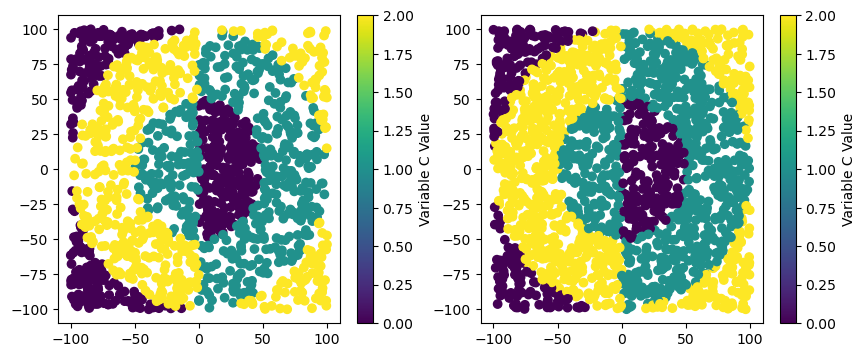

In [579]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_rings, y_train_rings, c=c_train_rings, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')


plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_rings, y_test_rings, c=c_test_rings, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')
plt.show()

In [580]:
# Combine X and Y for scaling
X_train_combined = np.hstack((x_train_rings, y_train_rings))
X_test_combined = np.hstack((x_test_rings, y_test_rings))

In [581]:
# Initialize the scaler
scaler = DataScaler(method="standardization")

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_combined)

# Transform the testing data
X_test_scaled = scaler.transform(X_test_combined)

# One-hot encode the class labels
encoder = OneHotEncoder(sparse=False)
c_train_rings_onehot = encoder.fit_transform(df_train_rings['c'].values.reshape(-1, 1))
c_test_rings_onehot = encoder.transform(df_test_rings['c'].values.reshape(-1, 1))

# Prepare the data in the format expected by the MLP class
training_data = [(X_train_scaled[i].reshape(-1, 1), c_train_rings_onehot[i].reshape(-1, 1)) for i in range(len(X_train_scaled))]
test_data = [(X_test_scaled[i].reshape(-1, 1), c_test_rings_onehot[i].reshape(-1,1)) for i in range(len(X_test_scaled))]

In [582]:
np.random.seed(42)

In [583]:
mlp = MLP(layer_sizes=[2, 10, 3], scaler=None, verbose=False)

In [584]:
mlp.train(
    training_data=training_data,
    epochs=1500,
    learning_rate=1,
    batch_size=32,
    adaptive_learning_rate=True,
    test_data=test_data,
    treshold_f1_train = 0.8,
    treshold_f1_test = 0.9,
    lambda_=0.001
)

Epoch:  0
0.30694845259329
Epoch:  15
0.8445680285298711
0.8393253983938185
Epoch:  30
0.8813822830034498
0.8703616280158412
Epoch:  45
0.9205088441764363
0.8974414631956585
Epoch:  60
0.9188252341200996
0.8942214272514489
Epoch:  75
0.9292508315658753
0.9089457730038685


In [585]:
def predict_and_display(mlp, test_data):
    predictions = []
    true_labels = []
    for (x, y_one_hot) in test_data:
        output, _ = mlp.feedforward(x)
        predicted_label = np.argmax(output)
        true_label = np.argmax(y_one_hot)  # Convert from one-hot to label
        predictions.append(predicted_label)
        true_labels.append(true_label)
        print(f"Input: {x}, True Label: {true_label}, Predicted Label: {predicted_label}")
    return predictions, true_labels

In [586]:
predictions, true_labels = predict_and_display(mlp, test_data)

# Now calculate the F1 score
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")

Input: [[-0.62253724]
 [ 0.66703303]], True Label: 2, Predicted Label: 2
Input: [[1.06481426]
 [0.22487108]], True Label: 1, Predicted Label: 1
Input: [[0.27595885]
 [1.33427929]], True Label: 1, Predicted Label: 1
Input: [[0.45441572]
 [0.45092189]], True Label: 0, Predicted Label: 0
Input: [[-1.60344134]
 [-0.6924797 ]], True Label: 0, Predicted Label: 0
Input: [[ 0.95193472]
 [-0.57148014]], True Label: 1, Predicted Label: 1
Input: [[-1.68563701]
 [ 0.78136561]], True Label: 0, Predicted Label: 0
Input: [[-0.5310812 ]
 [ 0.72905795]], True Label: 2, Predicted Label: 2
Input: [[ 0.77018327]
 [-0.04243538]], True Label: 0, Predicted Label: 0
Input: [[ 1.0617118 ]
 [-0.58846071]], True Label: 1, Predicted Label: 1
Input: [[ 1.7964922 ]
 [-0.46557344]], True Label: 2, Predicted Label: 1
Input: [[-1.09328698]
 [-1.0422526 ]], True Label: 2, Predicted Label: 2
Input: [[-1.01708502]
 [-0.51908688]], True Label: 2, Predicted Label: 2
Input: [[-1.1944176 ]
 [ 0.62609289]], True Label: 2, Pre

F1 Score: 0.9089457730038685


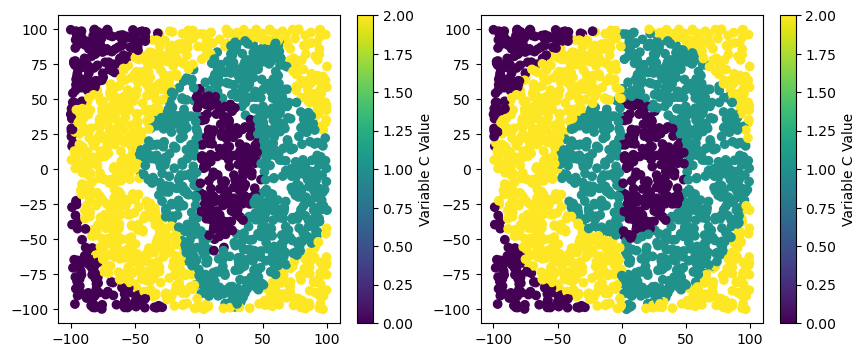

In [587]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_test_rings, y_test_rings, c=predictions, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')


plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_rings, y_test_rings, c=true_labels, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')
plt.show()

## EASY

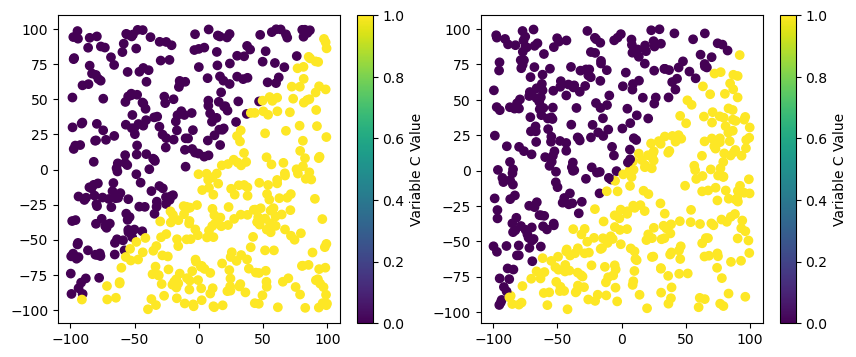

In [589]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_easy, y_train_easy, c=c_train_easy, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')


plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_easy, y_test_easy, c=c_test_easy, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')
plt.show()

In [590]:
# Combine X and Y for scaling
X_train_combined = np.hstack((x_train_easy, y_train_easy))
X_test_combined = np.hstack((x_test_easy, y_test_easy))

In [591]:
# Initialize the scaler
scaler = DataScaler(method="standardization")

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_combined)

# Transform the testing data
X_test_scaled = scaler.transform(X_test_combined)

# One-hot encode the class labels
encoder = OneHotEncoder(sparse=False)
c_train_easy_onehot = encoder.fit_transform(df_train_easy['c'].values.reshape(-1, 1))
c_test_easy_onehot = encoder.transform(df_test_easy['c'].values.reshape(-1, 1))

# Prepare the data in the format expected by the MLP class
training_data = [(X_train_scaled[i].reshape(-1, 1), c_train_easy_onehot[i].reshape(-1, 1)) for i in range(len(X_train_scaled))]
test_data = [(X_test_scaled[i].reshape(-1, 1), c_test_easy_onehot[i].reshape(-1,1)) for i in range(len(X_test_scaled))]

In [592]:
np.random.seed(42)

In [593]:
mlp = MLP(layer_sizes=[2, 5, 2], scaler=None, verbose=False)

In [594]:
mlp.train(
    training_data=training_data,
    epochs=200,
    learning_rate=1,
    batch_size=10,
    adaptive_learning_rate=True,
    test_data=test_data,
    treshold_f1_train = 0.95,
    treshold_f1_test = 0.99
)

Epoch:  0
0.3333333333333333
Epoch:  2
0.9799996799948798
0.977999207971487
Epoch:  4
0.9879982717511322
0.9859994959818552
Epoch:  6
0.9839959029511555
0.9759938544267333
Epoch:  8
0.9939997839922237
0.9899999599998399
Epoch:  10
0.9919994879672299
0.9919988478340881


In [595]:
predictions, true_labels = predict_and_display(mlp, test_data)

# Now calculate the F1 score
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")

Input: [[1.58731375]
 [0.66460909]], True Label: 1, Predicted Label: 1
Input: [[0.16502418]
 [1.04577865]], True Label: 0, Predicted Label: 0
Input: [[-0.99706303]
 [ 0.56471204]], True Label: 0, Predicted Label: 0
Input: [[-0.1955381 ]
 [-1.46275663]], True Label: 1, Predicted Label: 1
Input: [[0.17265171]
 [0.17316323]], True Label: 1, Predicted Label: 1
Input: [[ 0.27516549]
 [-0.362164  ]], True Label: 1, Predicted Label: 1
Input: [[-0.39905324]
 [-1.09597337]], True Label: 1, Predicted Label: 1
Input: [[1.25975996]
 [0.4505639 ]], True Label: 1, Predicted Label: 1
Input: [[ 1.22031994]
 [-0.97861352]], True Label: 1, Predicted Label: 1
Input: [[ 0.09301189]
 [-0.46830393]], True Label: 1, Predicted Label: 1
Input: [[0.77975152]
 [1.17936384]], True Label: 0, Predicted Label: 0
Input: [[ 0.63259512]
 [-0.64538155]], True Label: 1, Predicted Label: 1
Input: [[-0.28836484]
 [-0.21834465]], True Label: 0, Predicted Label: 0
Input: [[0.13536608]
 [0.63732743]], True Label: 0, Predicted

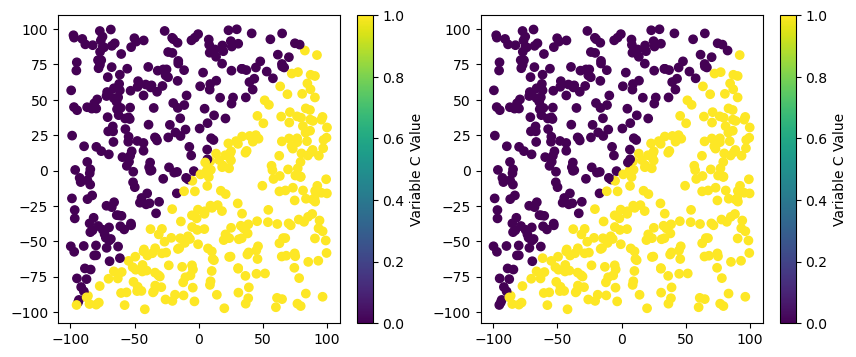

In [596]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_test_easy, y_test_easy, c=predictions, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')


plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_easy, y_test_easy, c=true_labels, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')
plt.show()

## XOR 3

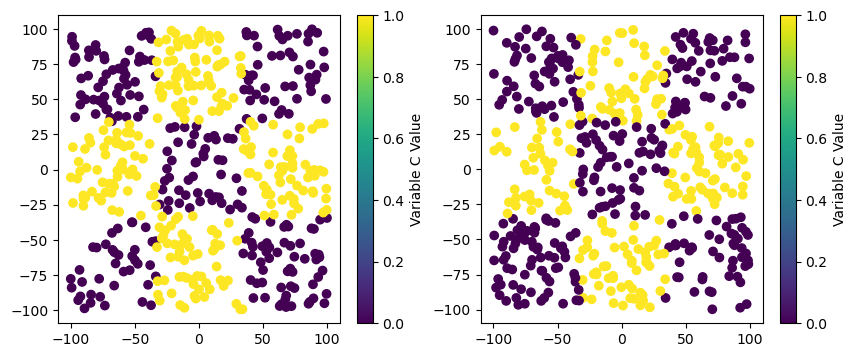

In [597]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train_xor, y_train_xor, c=c_train_xor, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')


plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_xor, y_test_xor, c=c_test_xor, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')
plt.show()

In [674]:
# Combine X and Y for scaling
X_train_combined = np.hstack((x_train_xor, y_train_xor))
X_test_combined = np.hstack((x_test_xor, y_test_xor))

In [679]:
# Initialize the scaler
scaler = DataScaler(method="standardization")

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_combined)

# Transform the testing data
X_test_scaled = scaler.transform(X_test_combined)

# One-hot encode the class labels
encoder = OneHotEncoder(sparse=False)
c_train_xor_onehot = encoder.fit_transform(df_train_xor['c'].values.reshape(-1, 1))
c_test_xor_onehot = encoder.transform(df_test_xor['c'].values.reshape(-1, 1))

# Prepare the data in the format expected by the MLP class
training_data = [(X_train_scaled[i].reshape(-1, 1), c_train_xor_onehot[i].reshape(-1, 1)) for i in range(len(X_train_scaled))]
test_data = [(X_test_scaled[i].reshape(-1, 1), c_test_xor_onehot[i].reshape(-1,1)) for i in range(len(X_test_scaled))]

In [680]:
np.random.seed(42)

In [681]:
mlp = MLP(layer_sizes=[2, 15, 15, 2], scaler=None, verbose=False)

In [682]:
mlp.train(
    training_data=training_data,
    epochs=5000,
    learning_rate=0.7,
    batch_size=100,
    adaptive_learning_rate=False,
    test_data=test_data,
    treshold_f1_train = 0.90,
    treshold_f1_test = 0.97
)

Epoch:  0
0.3333333333333333
Epoch:  50
0.9279585040983607
0.8962465669819958
Epoch:  100
0.9639994239907839
0.9528222547680291
Epoch:  150
0.984
0.9670244513693096
Epoch:  200
0.9879998079969279
0.9692319052834972
Epoch:  250
0.9859994959818553
0.9732992659352033


In [683]:
predictions, true_labels = predict_and_display(mlp, test_data)


Input: [[ 0.64562613]
 [-1.01175647]], True Label: 0, Predicted Label: 0
Input: [[0.68993152]
 [1.28719729]], True Label: 0, Predicted Label: 0
Input: [[1.37393663]
 [1.26897721]], True Label: 0, Predicted Label: 0
Input: [[ 0.16417896]
 [-0.16255185]], True Label: 0, Predicted Label: 0
Input: [[0.73771265]
 [0.7723257 ]], True Label: 0, Predicted Label: 0
Input: [[-0.84763323]
 [-0.56323835]], True Label: 1, Predicted Label: 1
Input: [[-0.40219041]
 [ 1.32595021]], True Label: 1, Predicted Label: 1
Input: [[-1.65932954]
 [-1.46879376]], True Label: 0, Predicted Label: 0
Input: [[0.69403884]
 [0.62437829]], True Label: 0, Predicted Label: 0
Input: [[-0.5316008 ]
 [-1.62976712]], True Label: 1, Predicted Label: 1
Input: [[-0.26595339]
 [ 0.68187968]], True Label: 1, Predicted Label: 1
Input: [[-0.7110203 ]
 [ 0.18740135]], True Label: 1, Predicted Label: 1
Input: [[-1.0590403 ]
 [ 0.67835018]], True Label: 0, Predicted Label: 0
Input: [[-0.96608361]
 [ 0.72223583]], True Label: 0, Predi

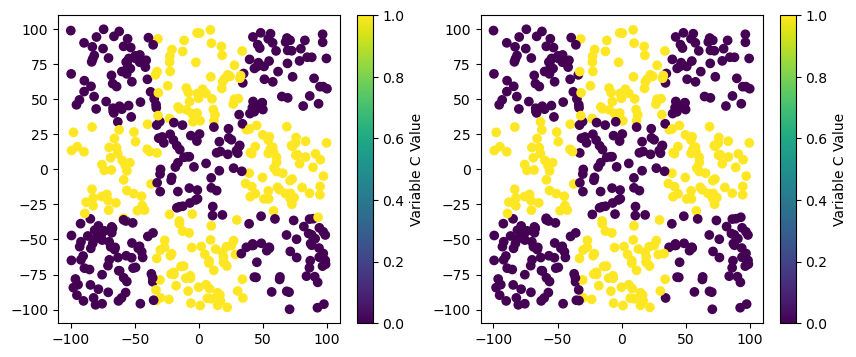

In [684]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_test_xor, y_test_xor, c=predictions, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')


plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_xor, y_test_xor, c=true_labels, cmap='viridis')
plt.colorbar(scatter, label='Variable C Value')
plt.show()